In [1]:
import numpy as np
import os
import kagglehub
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F

In [2]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, ds_file, labels, transform=None):
        self.transform = transform
        data_np = np.load(ds_file)
        labels_np = np.load(labels)
        self.data = torch.from_numpy(data_np)
        self.labels = torch.from_numpy(labels_np)
        self.length = data_np.shape[0]
    def __len__(self):
        return self.length
    def __getitem__(self, index):
        if self.transform:
            self.data = self.transform(self.data)

        return self.data[index], self.labels[index]

Using Colab cache for faster access to the 'crowd-counting' dataset.
Path to dataset files: /kaggle/input/crowd-counting
tensor([45], dtype=torch.uint8)


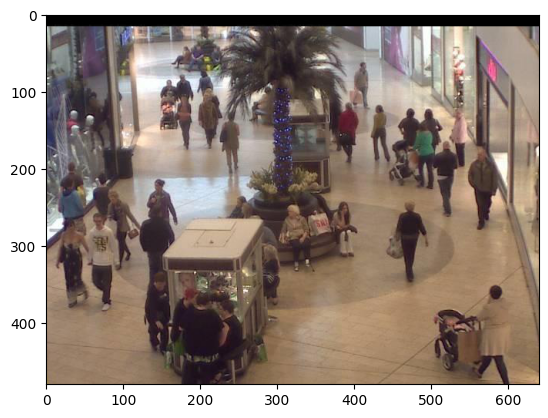

In [3]:
# Download latest version

path = kagglehub.dataset_download("fmena14/crowd-counting")

# train_data = np.load(os.path.join(path, "images.npy"))
all_data = DataSet(os.path.join(path, "images.npy"), os.path.join(path, "labels.npy"))
training_size = int(0.7 * len(all_data))
testing_size = (len(all_data)-training_size)

train_data, test_data = torch.utils.data.random_split(all_data, [training_size, testing_size])
# plt.imshow(train_data[0])
# train_data_tensor = torch.from_numpy(train_data).float()
# print(train_data_tensor.shape)
labels = np.load(os.path.join(path, "labels.npy"))


train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

print("Path to dataset files:", path)

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg)



# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# print(images)


# show images
imshow(images[0])
print(labels[0])

In [4]:
class ResNet50TransferLinReg(nn.Module):
    def __init__(self, unlock_layers=0):
        super().__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        self.fc1 = nn.Linear(in_features, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        for param in self.resnet.parameters():
            param.requires_grad = False
        if unlock_layers > 0:
            layers = list(self.resnet.parameters())
            unlock_layers = min(unlock_layers, len(layers))
            for param in layers[-unlock_layers:]:
                param.requires_grad = True

    def forward(self, x):
        x = self.resnet(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def plot_accuracy_graphs(title, train_graph, test_graph, file_name):
  fig, axes = plt.subplots(1,2)
  axes[0].plot(train_graph)
  axes[0].set_title("Training Accuracy")
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Error (average number of people missed)")
  axes[1].plot(test_graph)
  axes[1].set_title("Testing Accuracy")
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Error (average number of people missed)")
  fig.suptitle(title)
  fig.tight_layout()
  fig.show()
  fig.savefig(file_name)

def plot_loss_graphs(title, train_graph, test_graph, file_name):
  fig, axes = plt.subplots(1,2)
  axes[0].plot(train_graph)
  axes[0].set_title("Training Loss")
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Mean Squared Error")
  axes[1].plot(test_graph)
  axes[1].set_title("Testing Loss")
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Mean Squared Error")
  fig.suptitle(title)
  fig.tight_layout()
  fig.show()
  fig.savefig(file_name)

In [6]:
def train(model, device, epochs):
    train_acc_history = np.zeros(epochs)
    test_acc_history = np.zeros(epochs)
    train_loss_history = np.zeros(epochs)
    test_loss_history = np.zeros(epochs)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    for epoch in range(epochs):
        total = 0
        running_loss = 0.0
        running_acc = 0.0
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.permute(0, 3, 2, 1).float())
            loss = criterion(outputs.float(), labels.float())
            loss.backward()
            optimizer.step()
            total += labels.size(0)
            running_acc += torch.sum(torch.abs(outputs.float() - labels)).item()
            running_loss += loss.item()
        print(running_loss)
        train_acc_history[epoch] = running_acc / total
        train_loss_history[epoch] = running_loss / total
        total = 0
        running_loss = 0.0
        running_acc = 0.0

        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs.permute(0, 3, 2, 1).float())
                loss = criterion(outputs.float(), labels.float())
                total += labels.size(0)
                running_acc += torch.sum(torch.abs(outputs.float() - labels)).item()
                running_loss += loss.item()
        test_acc_history[epoch] = running_acc / total
        test_loss_history[epoch] = running_loss / total

    return train_acc_history, test_acc_history, train_loss_history, test_loss_history

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = ResNet50TransferLinReg(unlock_layers=9)
model = model.to(device)
train_acc_history, test_acc_history, train_loss_history, test_loss_history = train(model, device, 50)
torch.save(model.state_dict(), 'transfer_learning_model.pth')

cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 146MB/s]


21630.522431135178
5144.186159968376
2607.615608125925
1781.9862188845873
1581.8913466483355
1386.5602568089962
1270.5747609436512
1169.4659919925034
967.1714790314436
803.177273362875
949.6194395162165
955.2625812664628
958.0354693382978
961.7284800335765
681.53742037341
624.129007872194
763.8669093437493
742.2313234172761
642.8823890313506
582.4520726446062
559.3773647621274
541.3813703469932
452.8029628600925
499.0218648985028
529.1164561081678
634.8704816475511
600.1173524186015
570.797928225249
482.59598253667355
390.9490122050047
403.8648215010762
462.20508395694196
397.08761617541313
417.2128034029156
457.6671051494777
320.2230264618993
309.5971673661843
334.0193356256932
284.03620833158493
383.64358526840806
371.7064750213176
352.99299332872033
305.7655360661447
226.40114369615912
282.16653680056334
288.2473457399756
357.02472523599863
262.4445825777948
241.32101727463305
276.89479844272137


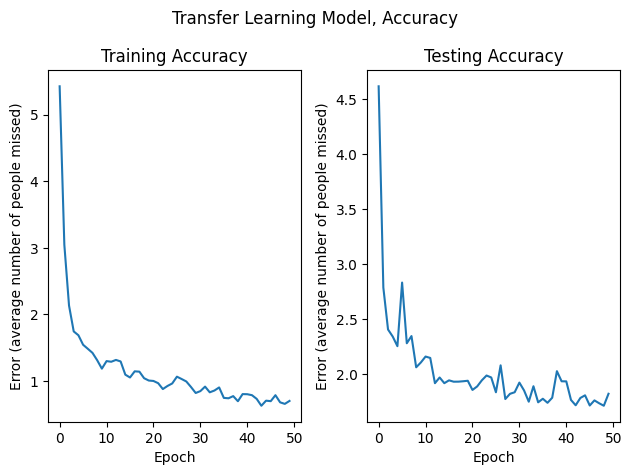

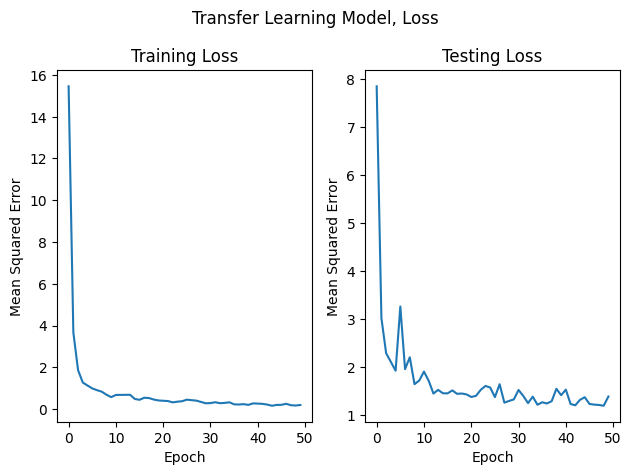

In [8]:
plot_accuracy_graphs("Transfer Learning Model, Accuracy", train_acc_history, test_acc_history, "transfer_learning_accuracy.png")
plot_loss_graphs("Transfer Learning Model, Loss", train_loss_history, test_loss_history, "transfer_learning_loss.png")

Predicted:  tensor([20.9042], device='cuda:0', grad_fn=<SelectBackward0>) tensor([29.0758], device='cuda:0', grad_fn=<SelectBackward0>) tensor([38.5434], device='cuda:0', grad_fn=<SelectBackward0>) tensor([28.7594], device='cuda:0', grad_fn=<SelectBackward0>)
Truth:  tensor([23], dtype=torch.uint8) tensor([27], dtype=torch.uint8) tensor([39], dtype=torch.uint8) tensor([26], dtype=torch.uint8)
Average error on the test images (in number of people missed): 1.822531 


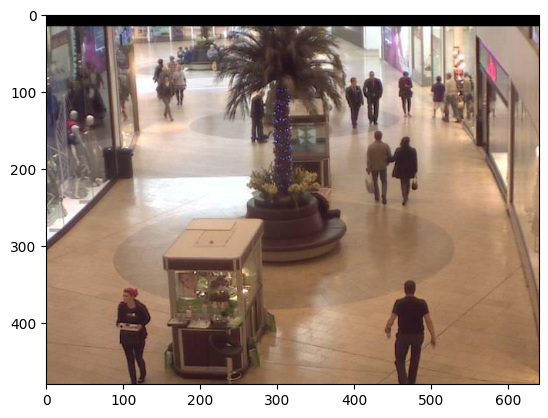

In [9]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images.to(device).permute(0, 3, 2, 1).float())

print('Predicted: ', ' '.join('%5s' % outputs[j]
                              for j in range(4)))
imshow(images[0])
print('Truth: ', ' '.join('%5s' % labels[j]
                              for j in range(4)))

total = 0
total_error = 0.0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images.permute(0, 3, 2, 1).float())
        total += labels.size(0)
        total_error += torch.sum(torch.abs(outputs.float() - labels)).item()

print('Average error on the test images (in number of people missed): %f ' %(
    total_error / total))